In [1]:
import json
import os
from ast import literal_eval
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras import layers, models

import fastestimator as fe
from fastestimator.op import TensorOp
from fastestimator.op.numpyop import Minmax
from fastestimator.trace.io import ModelSaver
from fastestimator.util.compute_overlap import compute_overlap

In [2]:
WIDTH = 512
HEIGHT = 512

### Load SVHN data set

#### Once this is done we will use COCO data set.

In [3]:
from fastestimator.dataset import svhn

In [4]:
# train_csv, test_csv, path = svhn.load_data('/home/ubuntu/')
path = '/home/ubuntu/SVHN'
train_csv = os.path.join(path,'train.csv')
test_csv = os.path.join(path, 'test.csv')

In [5]:
df = pd.read_csv(train_csv)

In [6]:
df.head()

,image,label,x1,y1,x2,y2
0,train/1.png,"[1, 9]","[246, 323]","[77, 81]","[327, 419]","[296, 300]"
1,train/2.png,"[2, 3]","[77, 98]","[29, 25]","[100, 124]","[61, 57]"
2,train/3.png,"[2, 5]","[17, 25]","[5, 5]","[25, 34]","[20, 20]"
3,train/4.png,"[9, 3]","[57, 72]","[13, 13]","[72, 85]","[47, 47]"
4,train/5.png,"[3, 1]","[52, 74]","[7, 10]","[73, 89]","[53, 56]"


### Create a smaller data set

#### TFRecords generation at high resolution (800x1280) is super slow. I am creating a smaller data set.

In [7]:
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

In [8]:
# train_small = train[0:3000]
# train_small.to_csv(os.path.join(path,'train_small.csv'), index=False)
# test_small = test[0:50]
# test_small.to_csv(os.path.join(path,'test_small.csv'),index=False)
                   

### Plot image and bounding box
#### Note: I found that 30.png, 18522.png are not correct.

In [9]:
index = 4000

image    train/4001.png
label            [6, 1]
x1             [23, 38]
y1               [3, 4]
x2             [37, 45]
y2             [28, 29]
Name: 4000, dtype: object

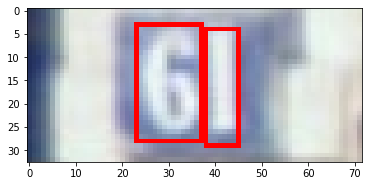

In [10]:
im = cv2.imread(os.path.join(path, df['image'][index]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
for box_index in range(len(literal_eval(df['label'][index]))):
    x1 = literal_eval(df['x1'][index])[box_index]
    y1 = literal_eval(df['y1'][index])[box_index]
    x2 = literal_eval(df['x2'][index])[box_index]
    y2 = literal_eval(df['y2'][index])[box_index]
    cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
ax.imshow(im)
df.loc[index]

### Create tfrecord writer

In [11]:
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, Minmax, Resize
from fastestimator.util import RecordWriter

In [12]:
class String2List(NumpyOp):
    # this thing converts '[1, 2, 3]' into np.array([1, 2, 3])
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data

In [13]:
class ResizeCocoStyle(Resize):
    def __init__(self, target_size, keep_ratio=False, inputs=None, outputs=None, mode=None):
        super().__init__(target_size, keep_ratio=keep_ratio, inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        img, x1, y1, x2, y2 = data
        if self.keep_ratio:
            original_ratio = img.shape[1] / img.shape[0]
            target_ratio = self.target_size[1] / self.target_size[0]
            if original_ratio >= target_ratio:
                pad = (img.shape[1] / target_ratio - img.shape[0]) / 2
                pad_boarder = (np.ceil(pad).astype(np.int), np.floor(pad).astype(np.int), 0, 0)
                y1 += np.ceil(pad).astype(np.int)
                y2 += np.ceil(pad).astype(np.int)
            else:
                pad = (img.shape[0] * target_ratio - img.shape[1]) / 2
                pad_boarder = (0, 0, np.ceil(pad).astype(np.int), np.floor(pad).astype(np.int))
                x1 += np.ceil(pad).astype(np.int)
                x2 += np.ceil(pad).astype(np.int)

            img = cv2.copyMakeBorder(img, *pad_boarder, cv2.BORDER_CONSTANT)
            
        img_resize = cv2.resize(img, (self.target_size[1], self.target_size[0]), self.resize_method)
        x1 = (np.array(x1) * self.target_size[1] / img.shape[1]).astype(np.int64)
        x2 = (np.array(x2) * self.target_size[1] / img.shape[1]).astype(np.int64)
        y1 = (np.array(y1) * self.target_size[0] / img.shape[0]).astype(np.int64)
        y2 = (np.array(y2) * self.target_size[0] / img.shape[0]).astype(np.int64)
        return img_resize, x1, y1, x2, y2

In [14]:
class GenerateTarget(NumpyOp):
    def __init__(self, inputs=None, outputs=None, mode=None, input_shape=(800, 800, 3)):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.pyramid_levels = [3, 4, 5, 6, 7]
        self.sizes = [32, 64, 128, 256, 512]
        self.strides = [8, 16, 32, 64, 128]
        self.ratios = np.array([0.5, 1, 2], dtype=np.float)
        self.scales = np.array([2**0, 2**(1.0 / 3.0), 2**(2.0 / 3.0)], dtype=np.float)

        self.anchors_list = np.zeros((0, 4))
        image_shapes = [(np.array(input_shape[:2]) + 2**pyra_level - 1) // (2**pyra_level)
                        for pyra_level in self.pyramid_levels]
        for idx, pyra_level in enumerate(self.pyramid_levels):
            base_size = self.sizes[idx]
            ratios = self.ratios
            scales = self.scales
            image_shape = image_shapes[idx]
            strides = self.strides[idx]
            anchors = self.generate_anchors_core(base_size, ratios, scales)
            shifted_anchors = self.shift(image_shape, strides, anchors)
            self.anchors_list = np.append(self.anchors_list, shifted_anchors, axis=0)

    def forward(self, data, state):
        label, x1, y1, x2, y2, image = data
        target_cls, target_loc = self.get_target(self.anchors_list, label, x1, y1, x2, y2, num_classes=11) # 10 classes + bg
        return target_cls, target_loc, self.anchors_list

    def get_target(self, anchorbox, label, x1, y1, x2, y2, num_classes=10):
        bg_index = num_classes - 1
        query_box = np.zeros((0, 4))
        query_label = np.zeros((0))
        for _x1, _y1, _x2, _y2, _label in zip(x1, y1, x2, y2, label):
            query_box = np.append(query_box, np.array([[_x1, _y1, _x2, _y2]]), axis=0)
            query_label = np.append(query_label, _label)

        overlap = compute_overlap(anchorbox.astype(np.float64), query_box.astype(np.float64))
        argmax_overlaps_inds = np.argmax(overlap, axis=1)
        max_overlaps = overlap[np.arange(overlap.shape[0]), argmax_overlaps_inds]
        positive_index = (max_overlaps > 0.5)
        ignore_index = (max_overlaps > 0.4) & ~positive_index
        negative_index = (max_overlaps <= 0.4)

        target_loc = get_loc_offset(query_box[argmax_overlaps_inds, :], anchorbox)
        target_cls = query_label[argmax_overlaps_inds]
        target_cls[negative_index] = bg_index
        target_cls[ignore_index] = -2  # ignore this example

        return target_cls, target_loc

    def generate_anchors_core(self, base_size, ratios, scales):
        num_anchors = len(ratios) * len(scales)
        # initialize output anchors
        anchors = np.zeros((num_anchors, 4))
        # scale base_size
        anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

        # compute areas of anchors
        areas = anchors[:, 2] * anchors[:, 3]

        # correct for ratios
        anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
        anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

        # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
        anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
        anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

        return anchors

    def shift(self, image_shape, stride, anchors):
        shift_x = (np.arange(0, image_shape[1]) + 0.5) * stride
        shift_y = (np.arange(0, image_shape[0]) + 0.5) * stride
        shift_x, shift_y = np.meshgrid(shift_x, shift_y)

        shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()

        A = anchors.shape[0]
        K = shifts.shape[0]
        all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
        all_anchors = all_anchors.reshape((K * A, 4))

        return all_anchors

### Util functions

In [15]:
def get_loc_offset(box_gt, box_anchor):
    mean = 0
    std = 0.2
    anchor_width_height = np.tile(box_anchor[:, 2:] - box_anchor[:, :2], [1, 2])
    delta = (box_gt - box_anchor) / anchor_width_height
    return delta / std

### Record writer

In [16]:
writer = RecordWriter(
    train_data=os.path.join(path, 'train.csv'),
    validation_data=os.path.join(path, 'test.csv'),
    save_dir=os.path.join(path, 'tfrecords'),
    ops=[
        ImageReader(inputs='image', outputs='image', parent_path=path),
        String2List(inputs=["label", "x1", "y1", "x2", "y2"], outputs=["label", "x1", "y1", "x2", "y2"]),
        ResizeCocoStyle((HEIGHT, WIDTH),
                        keep_ratio=True,
                        inputs=["image", "x1", "y1", "x2", "y2"],
                        outputs=["image", "x1", "y1", "x2", "y2"]),
        Minmax(inputs="image", outputs="image"),
        GenerateTarget(inputs=["label", "x1", "y1", "x2", "y2", "image"],
                       outputs=["target_cls", "target_loc", "base_loc"],
                       input_shape=(HEIGHT, WIDTH, 3))
    ])

### Pipeline

In [17]:
pipeline = fe.Pipeline(data=writer, batch_size=8, padded_batch=True, read_feature=["image", "target_cls", "target_loc","base_loc"])

In [18]:
# !rm -rf /home/ubuntu/SVHN/tfrecords/

In [19]:
batch_data = pipeline.show_results(mode='eval')

FastEstimator: Reading non-empty directory: /home/ubuntu/SVHN/tfrecords
FastEstimator: Found 33402 examples for train in /home/ubuntu/SVHN/tfrecords/train_summary0.json
FastEstimator: Found 13068 examples for eval in /home/ubuntu/SVHN/tfrecords/eval_summary0.json


In [20]:
# batch_data[0]['image'].shape

# batch_data[0].keys()

# batch_data[0]['base_loc'][1]

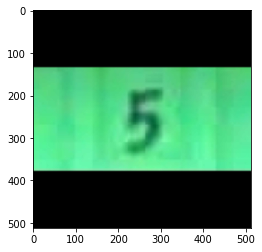

In [21]:
batch_index = 0
im = batch_data[0]['image'].numpy()[batch_index]
fig, ax = plt.subplots()
# for box_index in range(len(batch_data[0]['x1'].numpy()[batch_index])):
#     x1 = batch_data[0]['x1'].numpy()[batch_index][box_index]
#     y1 = batch_data[0]['y1'].numpy()[batch_index][box_index]
#     x2 = batch_data[0]['x2'].numpy()[batch_index][box_index]
#     y2 = batch_data[0]['y2'].numpy()[batch_index][box_index]
#     if x1 > 0:
#         im = cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2)

ax.imshow(im)

### Keras definitions

#### Classification head

In [22]:
def classification_sub_net(num_classes, num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(num_classes * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer=tf.initializers.constant(np.log(1 / 99))))
    model.add(layers.Reshape((-1, num_classes)))  # the output dimension is [batch, #anchor, #classes]
    return model

### Regression head

In [23]:
def regression_sub_net(num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(4 * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(layers.Reshape((-1, 4)))  # the output dimension is [batch, #anchor, 4]
    return model


## Define RetinaNet


In [24]:
def RetinaNet(input_shape, num_classes, num_anchor=9):
    inputs = tf.keras.Input(shape=input_shape)
    # FPN
    #     weights = '/home/ubuntu/ResNet-50-model.keras.h5'
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inputs, pooling=None)
    #     resnet50.load_weights(weights, by_name=True)
    assert resnet50.layers[80].name == "conv3_block4_out"
    C3 = resnet50.layers[80].output
    assert resnet50.layers[142].name == "conv4_block6_out"
    C4 = resnet50.layers[142].output
    assert resnet50.layers[-1].name == "conv5_block3_out"
    C5 = resnet50.layers[-1].output
    
    P5 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C5)
    P5_upsampling = layers.UpSampling2D()(P5)
    P4 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C4)
    P4 = layers.Add()([P5_upsampling, P4])
    P4_upsampling = layers.UpSampling2D()(P4)
    P3 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C3)
    
    P3 = layers.Add()([P4_upsampling, P3])
    
    P6 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', name="P6")(C5)
    P7 = layers.Activation('relu')(P6)
    P7 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', name="P7")(P7)
    P5 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P5")(P5)
    P4 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P4")(P4)
    P3 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P3")(P3)
    # classification subnet
    cls_subnet = classification_sub_net(num_classes=num_classes, num_anchor=num_anchor)
    P3_cls = cls_subnet(P3)
    P4_cls = cls_subnet(P4)
    P5_cls = cls_subnet(P5)
    P6_cls = cls_subnet(P6)
    P7_cls = cls_subnet(P7)
    cls_output = layers.Concatenate(axis=-2)([P3_cls, P4_cls, P5_cls, P6_cls, P7_cls])
    # localization subnet
    loc_subnet = regression_sub_net(num_anchor=num_anchor)
    P3_loc = loc_subnet(P3)
    P4_loc = loc_subnet(P4)
    P5_loc = loc_subnet(P5)
    P6_loc = loc_subnet(P6)
    P7_loc = loc_subnet(P7)
    loc_output = layers.Concatenate(axis=-2)([P3_loc, P4_loc, P5_loc, P6_loc, P7_loc])
    return tf.keras.Model(inputs=inputs, outputs=[cls_output, loc_output])

## Define loss

In [25]:
from fastestimator.op.tensorop import Loss

In [26]:
import pdb

In [27]:
class RetinaLoss(Loss):
    def focal_loss(self, cls_gt_example, cls_pred_example, num_classes, alpha=0.25, gamma=2.0):
        bg_index = num_classes - 1
        # cls_gt has shape [A], cls_pred is in [A, K]
        # gather the objects and background, discard the rest
        obj_idx = tf.where(tf.logical_and(tf.greater_equal(cls_gt_example, 0), tf.less(cls_gt_example, bg_index)))
        obj_bg_idx = tf.where(tf.greater_equal(cls_gt_example, 0))
        obj_bg_count = tf.cast(tf.shape(obj_bg_idx)[0], tf.float32)
        obj_count = tf.cast(tf.maximum(tf.shape(obj_idx)[0], 1), tf.float32)
        cls_gt_example = tf.one_hot(cls_gt_example, num_classes)
        cls_gt_example = tf.gather_nd(cls_gt_example, obj_bg_idx)
        cls_pred_example = tf.gather_nd(cls_pred_example, obj_bg_idx)
        cls_gt_example = tf.reshape(cls_gt_example, (-1, 1))
        cls_pred_example = tf.reshape(cls_pred_example, (-1, 1))
        # compute the focal weight on each selected anchor box
        alpha_factor = tf.ones_like(cls_gt_example) * alpha
        alpha_factor = tf.where(tf.equal(cls_gt_example, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(tf.equal(cls_gt_example, 1), 1 - cls_pred_example, cls_pred_example)
        focal_weight = alpha_factor * focal_weight**gamma / obj_count
        cls_loss = tf.losses.BinaryCrossentropy(reduction='sum')(cls_gt_example,
                                                                 cls_pred_example,
                                                                 sample_weight=focal_weight)
        return cls_loss

    def smooth_l1(self, loc_gt_example, loc_pred_example, cls_gt_example, cls_pred_example, num_classes):
        # loc_gt anf loc_pred has shape [A, 4]
        bg_index = num_classes - 1
        obj_idx = tf.where(tf.logical_and(tf.greater_equal(cls_gt_example, 0), tf.less(cls_gt_example, bg_index)))
        sigma = 3
        sigma_squared = sigma**3
        obj_count = tf.cast(tf.maximum(tf.shape(obj_idx)[0], 1), tf.float32)
        loc_gt = tf.gather_nd(loc_gt_example, obj_idx)
        loc_pred = tf.gather_nd(loc_pred_example, obj_idx)
        loc_gt = tf.reshape(loc_gt, (-1, 1))
        loc_pred = tf.reshape(loc_pred, (-1, 1))
        loc_diff = tf.abs(loc_gt - loc_pred)
        smooth_l1_loss = tf.where(tf.less(loc_diff, 1 / sigma_squared),
                                  0.5 * loc_diff**2 * sigma_squared,
                                  loc_diff - 0.5 / sigma_squared)
        smooth_l1_loss = tf.reduce_sum(smooth_l1_loss) / obj_count
        return smooth_l1_loss

    def forward(self, data, state):
        cls_gt, loc_gt, cls_pred, loc_pred = data
        cls_gt = tf.cast(cls_gt, tf.int32)
        batch_size = state["local_batch_size"]
        focal_loss = tf.map_fn(lambda x: self.focal_loss(x[0], x[1], num_classes=10+1), 
                                        (cls_gt, cls_pred),dtype=tf.float32, back_prop=False)
        smooth_l1_loss = tf.map_fn(lambda x: self.smooth_l1(x[0], x[1], x[2], x[3], num_classes=10+1),(loc_gt, loc_pred, cls_gt, cls_pred),
                                   dtype=tf.float32, back_prop=False)
        total_loss = tf.add(focal_loss, smooth_l1_loss)
        return total_loss
    
#         for idx in range(batch_size):
#             cls_gt_example = cls_gt[idx]
#             loc_gt_example = loc_gt[idx]
#             cls_pred_example = cls_pred[idx]
#             loc_pred_example = loc_pred[idx]
#             focal_loss, obj_idx = self.focal_loss(cls_gt_example, cls_pred_example, num_classes=10+1) # 10 classes + bg
#             smooth_l1_loss = self.smooth_l1(loc_gt_example, loc_pred_example, obj_idx)
#             total_loss.append(focal_loss + smooth_l1_loss)
#         total_loss = tf.convert_to_tensor(total_loss)
#         return total_loss

## Not using PredictBox yet

In [28]:
class PredictBox(TensorOp):
    def __init__(self, num_classes, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.num_classes = num_classes
        self.bg_index = num_classes - 1

    def forward(self, data, state):
        cls_pred, loc_pred, loc_base = data
        input_width = WIDTH
        input_height = HEIGHT
        top_n = 10
        score_threshold = 0.2
        std = 0.2
        mean = 0
        # convert the residual prediction to absolute prediction in (x1, y1, x2, y2)
        anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
        anchorbox = loc_base
        loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                                 elems=(loc_pred, anchor_w_h, anchorbox),
                                 dtype=tf.float32,
                                 back_prop=False)
        x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
        y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
        x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
        y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
        loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

        num_batch, num_anchor, _ = loc_pred_abs.shape
        cls_best_score = tf.reduce_max(cls_pred, axis=-1)
        cls_best_class = tf.argmax(cls_pred, axis=-1)

        cls_best_score = tf.where(tf.not_equal(cls_best_class, self.bg_index), cls_best_score, 0)

        # select top n anchor boxes to proceed
        # Padded Nonmax suppression with threshold
        selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
        valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
        return loc_pred_abs, selected_indices_padded, valid_outputs

## Create network

In [29]:
from fastestimator.op.tensorop.model import ModelOp

In [30]:
# prepare model
#10 + 1 comess from 10 classes plus bg class
model = fe.build(model_def=lambda: RetinaNet(input_shape=(HEIGHT, WIDTH, 3), num_classes=10 + 1),
                 model_name="retinanet",
                 optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                 loss_name="loss")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [31]:
network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs=["pred_cls", "pred_loc"]),
    RetinaLoss(inputs=("target_cls", "target_loc", "pred_cls", "pred_loc"), outputs="loss"),
])


### Create estimator

In [32]:
from fastestimator.trace.adapt.lr_controller import LRController

In [33]:
# prepare estimator
model_dir = '/home/ubuntu/SVHN/bestmodel'
traces = [
    LRController(model_name="retinanet", reduce_on_eval=True, reduce_patience=24, reduce_factor=0.5, min_lr=1e-08),
    ModelSaver(model_name="retinanet", save_dir=model_dir, save_best=True)
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=300,
                         steps_per_epoch=128,
                         log_steps=5,
                         traces=traces)

In [ ]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /home/ubuntu/SVHN/tfrecords
FastEstimator: Found 33402 examples for train in /home/ubuntu/SVHN/tfrecords/train_summary0.json
FastEstimator: Found 13068 examples for eval in /home/ubuntu/SVHN/tfrecords/eval_summary0.json
FastEstimator-Start: step: 0; total_train_steps: 38400; retinanet_lr: 1e-04; 
INFO:tensorflow:batch_all_reduce: 248 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
FastEstimator-Train: step: 0; loss: 1527.9053; retinanet_lr: 0.000

FastEstimator-Train: step: 300; loss: 2.8381042; examples/sec: 19.7; progress: 0.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 305; loss: 2.8413076; examples/sec: 18.8; progress: 0.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 310; loss: 3.1516533; examples/sec: 22.3; progress: 0.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 315; loss: 2.8319292; examples/sec: 23.2; progress: 0.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 320; loss: 2.7998767; examples/sec: 23.4; progress: 0.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 325; loss: 2.572017; examples/sec: 20.3; progress: 0.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 330; loss: 2.910353; examples/sec: 16.3; progress: 0.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 335; loss: 2.749403; examples/sec: 20.6; progress: 0.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 340; loss: 2.7966483; examples/sec: 22.2; progress: 0.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 345;

FastEstimator-Train: step: 655; loss: 2.1999774; examples/sec: 19.0; progress: 1.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 660; loss: 2.8038926; examples/sec: 15.4; progress: 1.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 665; loss: 2.1071424; examples/sec: 19.5; progress: 1.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 670; loss: 2.5848193; examples/sec: 21.5; progress: 1.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 675; loss: 2.44625; examples/sec: 21.6; progress: 1.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 680; loss: 2.685011; examples/sec: 21.5; progress: 1.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 685; loss: 2.5821285; examples/sec: 20.3; progress: 1.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 690; loss: 2.509256; examples/sec: 19.5; progress: 1.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 695; loss: 2.4363608; examples/sec: 15.5; progress: 1.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 700; 

FastEstimator-Train: step: 1020; loss: 1.934558; examples/sec: 20.3; progress: 2.7%; retinanet_lr: 0.0001; 
FastEstimator-ModelSaver: Saving model to /home/ubuntu/SVHN/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 1024; epoch: 7; loss: 2.7974045; min_loss: 2.7974045; since_best_loss: 0; 
FastEstimator-Train: step: 1025; loss: 2.1404486; examples/sec: 29.2; progress: 2.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1030; loss: 2.0699952; examples/sec: 33.5; progress: 2.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1035; loss: 2.0231683; examples/sec: 14.0; progress: 2.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1040; loss: 1.994738; examples/sec: 23.5; progress: 2.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1045; loss: 2.1616077; examples/sec: 27.2; progress: 2.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1050; loss: 2.1673908; examples/sec: 18.6; progress: 2.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1055; loss: 3.0973

FastEstimator-Train: step: 1375; loss: 2.0031295; examples/sec: 21.3; progress: 3.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1380; loss: 2.1294842; examples/sec: 20.5; progress: 3.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1385; loss: 1.9477084; examples/sec: 21.8; progress: 3.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1390; loss: 1.9689142; examples/sec: 22.9; progress: 3.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1395; loss: 1.8839521; examples/sec: 15.8; progress: 3.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1400; loss: 2.1351867; examples/sec: 20.9; progress: 3.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1405; loss: 2.0112004; examples/sec: 21.0; progress: 3.7%; retinanet_lr: 0.0001; 
FastEstimator-ModelSaver: Saving model to /home/ubuntu/SVHN/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 1408; epoch: 10; loss: 2.4622214; min_loss: 2.4622214; since_best_loss: 0; 
FastEstimator-Train: step: 1410; loss: 2.0

FastEstimator-Train: step: 1730; loss: 1.9618248; examples/sec: 19.4; progress: 4.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1735; loss: 1.9974692; examples/sec: 17.6; progress: 4.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1740; loss: 1.9937668; examples/sec: 18.3; progress: 4.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1745; loss: 1.9142066; examples/sec: 13.4; progress: 4.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1750; loss: 2.091828; examples/sec: 19.5; progress: 4.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1755; loss: 2.0277443; examples/sec: 20.7; progress: 4.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1760; loss: 2.083478; examples/sec: 19.6; progress: 4.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1765; loss: 1.9587086; examples/sec: 18.8; progress: 4.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1770; loss: 1.9300766; examples/sec: 17.3; progress: 4.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: 

FastEstimator-Train: step: 2085; loss: 2.0789356; examples/sec: 31.0; progress: 5.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2090; loss: 1.7467932; examples/sec: 30.2; progress: 5.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2095; loss: 1.7326186; examples/sec: 28.5; progress: 5.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2100; loss: 2.0073843; examples/sec: 28.0; progress: 5.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2105; loss: 1.8302093; examples/sec: 27.5; progress: 5.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2110; loss: 1.8308284; examples/sec: 28.5; progress: 5.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2115; loss: 1.963224; examples/sec: 26.6; progress: 5.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2120; loss: 1.8788716; examples/sec: 28.5; progress: 5.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2125; loss: 2.0550945; examples/sec: 27.3; progress: 5.5%; retinanet_lr: 0.0001; 
FastEstimator-Train:

FastEstimator-Train: step: 2445; loss: 1.713309; examples/sec: 20.6; progress: 6.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2450; loss: 1.8149046; examples/sec: 20.5; progress: 6.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2455; loss: 1.777671; examples/sec: 20.1; progress: 6.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2460; loss: 1.846317; examples/sec: 20.3; progress: 6.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2465; loss: 1.7195758; examples/sec: 21.9; progress: 6.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2470; loss: 1.7505459; examples/sec: 19.8; progress: 6.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2475; loss: 1.8748918; examples/sec: 20.0; progress: 6.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2480; loss: 2.1550488; examples/sec: 20.4; progress: 6.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2485; loss: 1.9540277; examples/sec: 19.3; progress: 6.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: s

FastEstimator-Train: step: 2805; loss: 1.973824; examples/sec: 15.3; progress: 7.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2810; loss: 1.85026; examples/sec: 18.2; progress: 7.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2815; loss: 1.8250498; examples/sec: 19.7; progress: 7.3%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 2816; epoch: 21; loss: 2.2747648; min_loss: 2.265575; since_best_loss: 1; 
FastEstimator-Train: step: 2820; loss: 1.7862852; examples/sec: 74.4; progress: 7.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2825; loss: 1.745305; examples/sec: 22.1; progress: 7.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2830; loss: 1.7843082; examples/sec: 21.5; progress: 7.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2835; loss: 1.7461162; examples/sec: 13.1; progress: 7.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2840; loss: 1.7560606; examples/sec: 20.8; progress: 7.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2845

FastEstimator-Train: step: 3165; loss: 1.603583; examples/sec: 28.3; progress: 8.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3170; loss: 1.7227066; examples/sec: 28.3; progress: 8.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3175; loss: 1.5006828; examples/sec: 29.0; progress: 8.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3180; loss: 1.7151184; examples/sec: 28.3; progress: 8.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3185; loss: 1.756661; examples/sec: 25.0; progress: 8.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3190; loss: 1.6682513; examples/sec: 26.5; progress: 8.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3195; loss: 1.7503822; examples/sec: 26.0; progress: 8.3%; retinanet_lr: 0.0001; 
FastEstimator-ModelSaver: Saving model to /home/ubuntu/SVHN/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 3200; epoch: 24; loss: 2.1851692; min_loss: 2.1851692; since_best_loss: 0; 
FastEstimator-Train: step: 3200; loss: 1.680

FastEstimator-Train: step: 3520; loss: 1.608887; examples/sec: 18.6; progress: 9.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3525; loss: 1.6186783; examples/sec: 19.2; progress: 9.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3530; loss: 1.9905899; examples/sec: 19.5; progress: 9.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3535; loss: 1.5291696; examples/sec: 20.0; progress: 9.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3540; loss: 1.758662; examples/sec: 20.3; progress: 9.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3545; loss: 1.6411406; examples/sec: 18.6; progress: 9.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3550; loss: 1.5554428; examples/sec: 18.4; progress: 9.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3555; loss: 1.7386066; examples/sec: 18.8; progress: 9.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3560; loss: 1.7522764; examples/sec: 16.2; progress: 9.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: 

FastEstimator-Train: step: 3880; loss: 1.4970037; examples/sec: 19.6; progress: 10.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3885; loss: 1.7200456; examples/sec: 20.2; progress: 10.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3890; loss: 1.8220656; examples/sec: 20.5; progress: 10.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3895; loss: 1.5276228; examples/sec: 18.2; progress: 10.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3900; loss: 1.7635484; examples/sec: 19.5; progress: 10.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3905; loss: 1.6093185; examples/sec: 19.7; progress: 10.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3910; loss: 1.5841436; examples/sec: 20.6; progress: 10.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3915; loss: 1.6667964; examples/sec: 19.9; progress: 10.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3920; loss: 1.6279211; examples/sec: 20.3; progress: 10.2%; retinanet_lr: 0.0001; 
FastEstima

FastEstimator-Train: step: 4230; loss: 1.5989246; examples/sec: 58.8; progress: 11.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4235; loss: 1.6097612; examples/sec: 30.0; progress: 11.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4240; loss: 1.5528855; examples/sec: 27.3; progress: 11.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4245; loss: 1.6515605; examples/sec: 14.6; progress: 11.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4250; loss: 1.5933714; examples/sec: 30.9; progress: 11.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4255; loss: 1.6363275; examples/sec: 29.7; progress: 11.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4260; loss: 1.4395778; examples/sec: 26.3; progress: 11.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4265; loss: 1.4633641; examples/sec: 27.5; progress: 11.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4270; loss: 1.7005236; examples/sec: 25.2; progress: 11.1%; retinanet_lr: 0.0001; 
FastEstima

FastEstimator-Train: step: 4595; loss: 1.4926836; examples/sec: 21.3; progress: 12.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4600; loss: 1.5613234; examples/sec: 20.4; progress: 12.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4605; loss: 1.519846; examples/sec: 19.6; progress: 12.0%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 4608; epoch: 35; loss: 2.0857196; min_loss: 2.074928; since_best_loss: 3; 
FastEstimator-Train: step: 4610; loss: 1.5266798; examples/sec: 33.8; progress: 12.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4615; loss: 1.450922; examples/sec: 30.5; progress: 12.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4620; loss: 1.6163282; examples/sec: 20.1; progress: 12.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4625; loss: 1.4164155; examples/sec: 14.3; progress: 12.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4630; loss: 1.3784574; examples/sec: 20.7; progress: 12.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: 

FastEstimator-Train: step: 4950; loss: 1.4791911; examples/sec: 20.5; progress: 12.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4955; loss: 1.5907537; examples/sec: 20.7; progress: 12.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4960; loss: 1.4966047; examples/sec: 20.0; progress: 12.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4965; loss: 1.4146969; examples/sec: 18.2; progress: 12.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4970; loss: 1.438186; examples/sec: 18.7; progress: 12.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4975; loss: 1.5150377; examples/sec: 19.8; progress: 13.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4980; loss: 1.5663586; examples/sec: 18.4; progress: 13.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4985; loss: 1.5228386; examples/sec: 17.8; progress: 13.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 4990; loss: 1.5340338; examples/sec: 21.1; progress: 13.0%; retinanet_lr: 0.0001; 
FastEstimat

FastEstimator-Train: step: 5305; loss: 1.3295752; examples/sec: 27.6; progress: 13.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5310; loss: 1.4896415; examples/sec: 27.4; progress: 13.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5315; loss: 1.6642385; examples/sec: 28.5; progress: 13.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5320; loss: 1.4084196; examples/sec: 27.1; progress: 13.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5325; loss: 1.3985765; examples/sec: 28.7; progress: 13.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5330; loss: 1.4555404; examples/sec: 25.5; progress: 13.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5335; loss: 1.4124177; examples/sec: 23.1; progress: 13.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5340; loss: 1.315126; examples/sec: 25.8; progress: 13.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5345; loss: 1.3008661; examples/sec: 26.0; progress: 13.9%; retinanet_lr: 0.0001; 
FastEstimat

FastEstimator-Train: step: 5665; loss: 1.423082; examples/sec: 19.2; progress: 14.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5670; loss: 1.4652742; examples/sec: 19.8; progress: 14.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5675; loss: 1.602155; examples/sec: 18.7; progress: 14.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5680; loss: 1.4050841; examples/sec: 19.5; progress: 14.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5685; loss: 1.5153121; examples/sec: 19.3; progress: 14.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5690; loss: 1.4311125; examples/sec: 19.2; progress: 14.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5695; loss: 1.6404847; examples/sec: 19.5; progress: 14.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5700; loss: 1.5728815; examples/sec: 18.0; progress: 14.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 5705; loss: 1.6802698; examples/sec: 18.9; progress: 14.9%; retinanet_lr: 0.0001; 
FastEstimato

FastEstimator-Train: step: 6025; loss: 1.5480376; examples/sec: 19.5; progress: 15.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6030; loss: 1.4063885; examples/sec: 19.0; progress: 15.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6035; loss: 1.5349727; examples/sec: 16.2; progress: 15.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6040; loss: 1.3610709; examples/sec: 19.9; progress: 15.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6045; loss: 1.4824164; examples/sec: 18.2; progress: 15.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6050; loss: 1.3964269; examples/sec: 17.7; progress: 15.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6055; loss: 1.4903848; examples/sec: 19.7; progress: 15.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6060; loss: 1.4042925; examples/sec: 17.3; progress: 15.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6065; loss: 1.460238; examples/sec: 18.6; progress: 15.8%; retinanet_lr: 0.0001; 
FastEstimat

FastEstimator-Train: step: 6390; loss: 1.1439754; examples/sec: 22.4; progress: 16.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6395; loss: 1.4209571; examples/sec: 27.9; progress: 16.7%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 6400; epoch: 49; loss: 2.1494067; min_loss: 2.0412874; since_best_loss: 9; 
FastEstimator-Train: step: 6400; loss: 1.4788635; examples/sec: 25.9; progress: 16.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6405; loss: 1.421387; examples/sec: 59.0; progress: 16.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6410; loss: 1.529398; examples/sec: 20.2; progress: 16.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6415; loss: 1.5080519; examples/sec: 21.8; progress: 16.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6420; loss: 1.3086767; examples/sec: 20.5; progress: 16.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6425; loss: 1.5487965; examples/sec: 20.0; progress: 16.7%; retinanet_lr: 0.0001; 
FastEstimator-Train:

FastEstimator-Train: step: 6745; loss: 1.5182362; examples/sec: 21.6; progress: 17.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6750; loss: 1.4701174; examples/sec: 20.5; progress: 17.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6755; loss: 1.5045958; examples/sec: 19.3; progress: 17.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6760; loss: 1.4298156; examples/sec: 20.4; progress: 17.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6765; loss: 1.3666394; examples/sec: 21.0; progress: 17.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6770; loss: 1.6423367; examples/sec: 19.3; progress: 17.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6775; loss: 1.2783599; examples/sec: 18.9; progress: 17.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 6780; loss: 1.2475948; examples/sec: 21.2; progress: 17.7%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 6784; epoch: 52; loss: 2.111845; min_loss: 2.0251925; since_best_loss: 1; 
FastEstimator-Train

FastEstimator-Train: step: 7100; loss: 1.3982053; examples/sec: 19.4; progress: 18.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7105; loss: 1.2665784; examples/sec: 20.5; progress: 18.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7110; loss: 1.1906261; examples/sec: 19.5; progress: 18.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7115; loss: 1.7094969; examples/sec: 19.7; progress: 18.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7120; loss: 1.4390206; examples/sec: 18.8; progress: 18.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7125; loss: 1.3710405; examples/sec: 20.0; progress: 18.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7130; loss: 1.7080086; examples/sec: 18.9; progress: 18.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7135; loss: 1.4509389; examples/sec: 19.1; progress: 18.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7140; loss: 1.3183533; examples/sec: 18.6; progress: 18.6%; retinanet_lr: 0.0001; 
FastEstima

FastEstimator-Train: step: 7460; loss: 1.3209648; examples/sec: 21.0; progress: 19.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7465; loss: 1.3279412; examples/sec: 20.6; progress: 19.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7470; loss: 1.1637402; examples/sec: 20.7; progress: 19.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7475; loss: 1.4110885; examples/sec: 21.8; progress: 19.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7480; loss: 1.2782516; examples/sec: 21.4; progress: 19.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7485; loss: 1.3525305; examples/sec: 14.7; progress: 19.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7490; loss: 1.3693405; examples/sec: 22.6; progress: 19.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7495; loss: 1.1935256; examples/sec: 24.8; progress: 19.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7500; loss: 1.2471303; examples/sec: 20.7; progress: 19.5%; retinanet_lr: 0.0001; 
FastEstima

FastEstimator-Train: step: 7820; loss: 1.3313711; examples/sec: 21.4; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7825; loss: 1.559644; examples/sec: 21.3; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7830; loss: 1.4439161; examples/sec: 19.3; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7835; loss: 1.4800494; examples/sec: 17.5; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7840; loss: 1.3079078; examples/sec: 18.4; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7845; loss: 1.2600856; examples/sec: 17.3; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7850; loss: 1.4955698; examples/sec: 20.6; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7855; loss: 1.382088; examples/sec: 19.9; progress: 20.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 7860; loss: 1.3677622; examples/sec: 20.0; progress: 20.5%; retinanet_lr: 0.0001; 
FastEstimato

FastEstimator-Train: step: 8185; loss: 1.4200641; examples/sec: 20.8; progress: 21.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8190; loss: 1.4314408; examples/sec: 19.4; progress: 21.3%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 8192; epoch: 63; loss: 2.1195147; min_loss: 2.0235188; since_best_loss: 9; 
FastEstimator-Train: step: 8195; loss: 1.4466344; examples/sec: 47.2; progress: 21.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8200; loss: 1.4219155; examples/sec: 25.3; progress: 21.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8205; loss: 1.5458136; examples/sec: 20.4; progress: 21.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8210; loss: 1.3902348; examples/sec: 19.6; progress: 21.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8215; loss: 1.4469042; examples/sec: 19.7; progress: 21.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8220; loss: 1.338475; examples/sec: 19.2; progress: 21.4%; retinanet_lr: 0.0001; 
FastEstimator-Train

FastEstimator-Train: step: 8545; loss: 1.3134522; examples/sec: 23.6; progress: 22.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8550; loss: 1.3442153; examples/sec: 25.0; progress: 22.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8555; loss: 1.4095199; examples/sec: 25.5; progress: 22.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8560; loss: 1.0995139; examples/sec: 26.1; progress: 22.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8565; loss: 1.4227649; examples/sec: 26.0; progress: 22.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8570; loss: 1.3695707; examples/sec: 23.1; progress: 22.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8575; loss: 1.2689347; examples/sec: 25.9; progress: 22.3%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 8576; epoch: 66; loss: 2.0875175; min_loss: 2.0235188; since_best_loss: 12; 
FastEstimator-Train: step: 8580; loss: 1.3474343; examples/sec: 74.7; progress: 22.3%; retinanet_lr: 0.0001; 
FastEstimator-Tra

FastEstimator-Train: step: 8905; loss: 1.1844065; examples/sec: 20.3; progress: 23.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8910; loss: 1.3993824; examples/sec: 19.7; progress: 23.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8915; loss: 1.4549028; examples/sec: 17.1; progress: 23.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8920; loss: 1.4569867; examples/sec: 21.7; progress: 23.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8925; loss: 1.4827555; examples/sec: 21.8; progress: 23.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8930; loss: 1.2517464; examples/sec: 19.9; progress: 23.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8935; loss: 1.3014907; examples/sec: 18.8; progress: 23.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8940; loss: 1.278549; examples/sec: 18.1; progress: 23.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 8945; loss: 1.2233386; examples/sec: 18.6; progress: 23.3%; retinanet_lr: 0.0001; 
FastEstimat

FastEstimator-Train: step: 9265; loss: 1.1890326; examples/sec: 20.7; progress: 24.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9270; loss: 1.2249944; examples/sec: 20.1; progress: 24.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9275; loss: 1.2912303; examples/sec: 19.8; progress: 24.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9280; loss: 1.3371354; examples/sec: 20.1; progress: 24.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9285; loss: 1.3803825; examples/sec: 20.1; progress: 24.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9290; loss: 1.2255661; examples/sec: 18.6; progress: 24.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9295; loss: 1.3428998; examples/sec: 18.2; progress: 24.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9300; loss: 1.2554655; examples/sec: 20.7; progress: 24.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9305; loss: 1.2892331; examples/sec: 13.7; progress: 24.2%; retinanet_lr: 0.0001; 
FastEstima

FastEstimator-Train: step: 9625; loss: 1.278182; examples/sec: 20.2; progress: 25.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9630; loss: 1.2076747; examples/sec: 20.5; progress: 25.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9635; loss: 1.1564417; examples/sec: 13.2; progress: 25.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9640; loss: 1.2714843; examples/sec: 17.9; progress: 25.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9645; loss: 1.21312; examples/sec: 21.8; progress: 25.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9650; loss: 1.1498318; examples/sec: 21.2; progress: 25.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9655; loss: 1.1873269; examples/sec: 23.2; progress: 25.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9660; loss: 1.1316941; examples/sec: 24.8; progress: 25.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9665; loss: 1.2731138; examples/sec: 25.5; progress: 25.2%; retinanet_lr: 0.0001; 
FastEstimator

FastEstimator-Train: step: 9985; loss: 1.3010567; examples/sec: 25.5; progress: 26.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9990; loss: 1.3172843; examples/sec: 38.9; progress: 26.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 9995; loss: 1.1483604; examples/sec: 19.6; progress: 26.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 10000; loss: 1.0322626; examples/sec: 18.3; progress: 26.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 10005; loss: 1.1961904; examples/sec: 18.9; progress: 26.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 10010; loss: 1.2928978; examples/sec: 18.7; progress: 26.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 10015; loss: 1.283922; examples/sec: 19.1; progress: 26.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 10020; loss: 1.0825391; examples/sec: 19.5; progress: 26.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 10025; loss: 1.2308308; examples/sec: 20.2; progress: 26.1%; retinanet_lr: 0.0001; 
FastE

FastEstimator-Train: step: 10345; loss: 1.1478696; examples/sec: 21.1; progress: 26.9%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10350; loss: 1.1689558; examples/sec: 20.2; progress: 27.0%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10355; loss: 1.3467937; examples/sec: 19.2; progress: 27.0%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10360; loss: 1.1102581; examples/sec: 20.2; progress: 27.0%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10365; loss: 1.1918217; examples/sec: 18.8; progress: 27.0%; retinanet_lr: 5e-05; 
FastEstimator-Eval: step: 10368; epoch: 80; loss: 2.0740511; min_loss: 2.0235188; since_best_loss: 26; 
FastEstimator-Train: step: 10370; loss: 1.0942733; examples/sec: 33.4; progress: 27.0%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10375; loss: 1.1707551; examples/sec: 29.9; progress: 27.0%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10380; loss: 1.2067367; examples/sec: 18.9; progress: 27.0%; retinanet_lr: 5e-05; 
FastEstimator-Tr

FastEstimator-Train: step: 10705; loss: 0.8910854; examples/sec: 19.6; progress: 27.9%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10710; loss: 0.9892461; examples/sec: 18.5; progress: 27.9%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10715; loss: 0.9284508; examples/sec: 21.3; progress: 27.9%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10720; loss: 0.9840871; examples/sec: 20.7; progress: 27.9%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10725; loss: 0.9974823; examples/sec: 21.1; progress: 27.9%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10730; loss: 0.9418473; examples/sec: 14.1; progress: 27.9%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10735; loss: 1.0247995; examples/sec: 18.7; progress: 28.0%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10740; loss: 0.8849281; examples/sec: 19.5; progress: 28.0%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 10745; loss: 0.9450133; examples/sec: 19.5; progress: 28.0%; retinanet_lr: 5e-05; 
FastEstima

## Inference

In [35]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join(path, 'bestmodel','retinanet_best_loss.h5'))

In [38]:
batch_data = pipeline.show_results(mode='eval')
batch_images = batch_data[0]['image']

FastEstimator: Reading non-empty directory: /home/ubuntu/SVHN/tfrecords
FastEstimator: Found 33402 examples for train in /home/ubuntu/SVHN/tfrecords/train_summary0.json
FastEstimator: Found 13068 examples for eval in /home/ubuntu/SVHN/tfrecords/eval_summary0.json


In [42]:
batch_data[0].keys()

dict_keys(['target_cls', 'image', 'target_loc', 'base_loc'])

In [43]:
batch_images = batch_data[0]['image']
batch_base_loc = batch_data[0]['base_loc']
batch_images.shape

TensorShape([32, 512, 512, 3])

In [44]:
 cls_pred, loc_pred = model.predict(batch_images)

### Below cell Equivalent to  predict_box 

In [45]:
# equi of __init__
num_classes = 10 + 1
bg_index = num_classes - 1




loc_base = batch_base_loc
cls_pred = tf.convert_to_tensor(cls_pred)
loc_pred = tf.convert_to_tensor(loc_pred)

input_width = WIDTH
input_height = HEIGHT
top_n = 10
score_threshold = 0.2
std = 0.2
mean = 0


anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
anchorbox = loc_base
loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                             elems=(loc_pred, anchor_w_h, anchorbox),
                             dtype=tf.float32,
                             back_prop=False)
x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

num_batch, num_anchor, _ = loc_pred_abs.shape
cls_best_score = tf.reduce_max(cls_pred, axis=-1)
cls_best_class = tf.argmax(cls_pred, axis=-1)

cls_best_score = tf.where(tf.not_equal(cls_best_class, bg_index), cls_best_score, 0)

# select top n anchor boxes to proceed
# Padded Nonmax suppression with threshold
selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)

valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
# return loc_pred_abs, selected_indices_padded, valid_outputs


In [46]:
type(cls_pred), cls_pred.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([32, 49104, 11]))

In [47]:
cls_pred = cls_pred.numpy()
loc_pred_abs = loc_pred_abs.numpy()


In [106]:
# cls_pred pertains to batch, whereas ele_cls_pred pertains to an element of a batch

batch_idx = np.random.randint(0,32)
elem_selected_indices = selected_indices_padded[batch_idx]
elem_valid_outputs = valid_outputs[batch_idx]
elem_cls_pred = cls_pred[batch_idx]
elem_loc_pred_abs = loc_pred_abs[batch_idx]

indices = elem_selected_indices[:elem_valid_outputs] # indices into anchor boxes
indices = indices.numpy()

predicted_cls = elem_cls_pred[indices] 
predicted_cls = np.argmax(predicted_cls,-1)
predicted_bbox = elem_loc_pred_abs[indices]


In [107]:
im = batch_images[batch_idx]
im = im.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


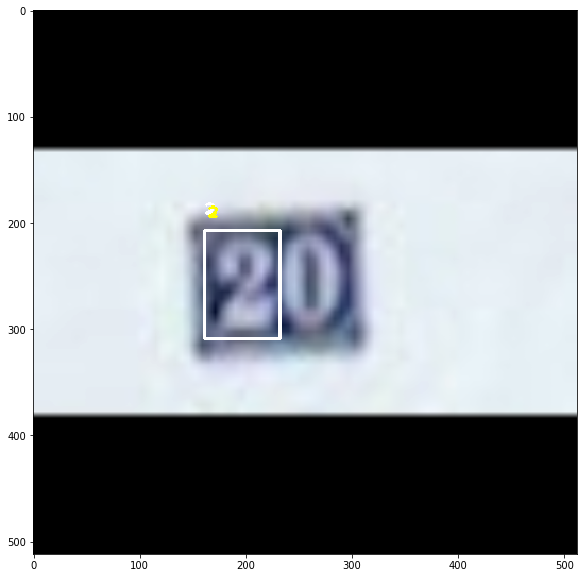

In [109]:
fig = plt.figure(figsize=(10,10))
for bbox_index in range(len(predicted_bbox)):
    x1,y1,x2,y2 = predicted_bbox[bbox_index]
    cls = predicted_cls[bbox_index]
    cls = str(cls)
    cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)
    cv2.putText(im, cls, (int(x1), int(y1)-15), font, 1, (255,255,255),2, cv2.LINE_AA, False)
    cv2.putText(im, cls, (int(x1)+3, int(y1)-12), font, 1, (255,255,0),2, cv2.LINE_AA, False)
    
plt.imshow(im)

In [98]:
predicted_cls

array([9, 1])

In [100]:
# font = cv2.FONT_HERSHEY_PLAIN